# Text Classification

#### Problem Statement

We have a collection of SMS messages. Some of these messages are spam and the rest are genuine.
Our task is to build a system that would automatically detect whether a message is spam or not.

#### Import Libraries

In [9]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import AutoModel, BertTokenizerFast

In [10]:
# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU available :", torch.cuda.is_available)

GPU available : <function is_available at 0x7eac2dd5b600>


In [11]:
# import torch

print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU Available: True
Device Name: Tesla T4


In [12]:
# Load Dataset
df = pd.read_csv("/content/sample_data/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

#### Import BERT and BERT Tokenizer

In [14]:
#import BERT-base pretrained model
#from transformers import AutoModel, BertTokenizerFast
bert = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
#Load the BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [16]:
# Sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

In [17]:
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

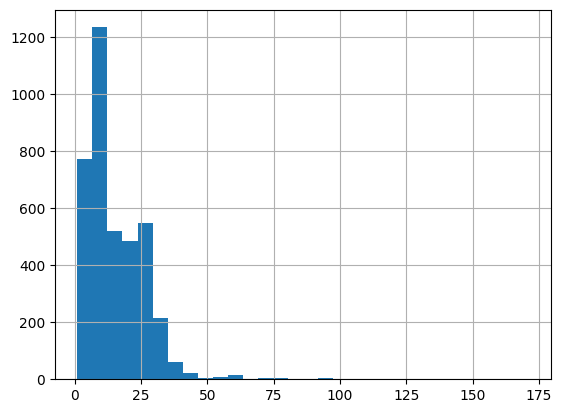

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

####

We will set 25 as the padding length because
1. We can clearly see that most of the messages have a length of 25 words or less.
   Whereas the maximum length is 175. So, if we select 175 as the padding length then all the
   input sequences will have length 175 and most of the tokens in those sequences will be padding tokens
    which are not going to help the model learn anything useful and on top of that, it will make the training slower.

In [19]:
# tokenize and encode sequences in the training set

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding = "max_length",
    truncation=True,
    return_tensors="pt"
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding = "max_length",
    truncation=True,
    return_tensors="pt"
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding = "max_length",
    truncation=True,
    return_tensors="pt"
)

#### Now, we will convert the integer sequences to tensors

In [20]:
## convert list to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<ipython-input-20-1760610028>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids'])
<ipython-input-20-1760610028>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask'])
<ipython-input-20-1760610028>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_seq = torch.tensor(tokens_val['input_ids'])
<ipython-input-20-1760610028>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

####  Now we will create Dataloaders for both "train" set and "validation" set. These dataloaders will pass batches of "train_data" and "validation_data" as input to the model during the training phase

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [22]:

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)     # Wraps input, mask, and labels together
train_sampler = RandomSampler(train_data)                      # Shuffles data each epoch
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # Creates batches and feeds them into the model


# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Define Model Architecture

In [23]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [24]:
#now let’s define our model architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      self.dropout = nn.Dropout(0.1)  # droput layer
      self.relu =  nn.ReLU()  # relu activation function
      self.fc1 = nn.Linear(768, 512)  # dense layer 1
      self.fc2 = nn.Linear(512,2)   # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)   #softmax activation function


    #define the forward pass
    def forward(self, sent_id, mask):
      #_, cls_hs = self.bert(sent_id, attention_mask=mask)   #pass the inputs to the model

      output = self.bert(sent_id, attention_mask=mask)   # get BERT outputs
      cls_hs = output.last_hidden_state[:, 0]  # CLS token / ## take <CLS> token's hidden state
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)   # output layer
      x = self.softmax(x)   # apply softmax activation

      return x

In [25]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert).to(device)

'''
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
'''

'\n# pass the pre-trained BERT to our define architecture\nmodel = BERT_Arch(bert)\n\n# push the model to GPU\nmodel = model.to(device)\n'

In [26]:
#Uninstall Existing CPU-Only PyTorch
#!pip uninstall torch torchvision torchaudio -y

In [27]:
#Install GPU (CUDA) Enabled PyTorch
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [28]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available()) #should be True

2.6.0+cu124
12.4
True


In [29]:
# specify GPU
device = torch.device("cuda")

#### We will use AdamW as our optimizer

In [30]:
# optimizer from hugging face transformers
#from transformers import AdamW
from torch.optim import AdamW


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

####
There is an imbalance in our dataset. The majority of the observations are not Spam.
So we will first compute class_weights for the labels in the train_set and then pass these weights to the
loss_function so that it takes care of the class_imbalance

In [31]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [32]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
print(weights)

# push to GPU
#weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)
print(cross_entropy)

# number of training epochs
epochs = 10

tensor([0.5774, 3.7285], device='cuda:0')
NLLLoss()


### Fine-Tune BERT

So, till now we have defined our Architecture, Loss function and Optimizer, and our dataloaders too.
Now we have to define a couple of functions to train(fine-tune) and evaluate the model, respectively.

### Functions to Train the model

In [33]:
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model prediction
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches
        if step % 50 == 0 and not step == 0:
            print ("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))

        # push the batch to GPU
        #batch = [r.to(device) for r in batch]

        #sent_id, mask, labels = batch
        sent_id, mask, labels = [r.to(device) for r in batch]


        # clear previously calculated gradients
        model.zero_grad()

        # get model prediction for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the gradients to 1.0 - helps in exploding gradient problem
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

        # update the parameters
        optimizer.step()

        # model predictions are stored on GPU. so, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


#### We will use following function to evaluate the model. It will use the "validation_set" data

In [34]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step, batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch #modified since its in CPU and not GPU

    sent_id, mask, labels = [r.to(device) for r in batch]



    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

#### Now we will finally start fine-tuning of the model.

In [35]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()   # train model

    valid_loss, _ = evaluate()   # evaluate model

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


<ipython-input-33-642265194>:39: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.647
Validation Loss: 0.592

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.565
Validation Loss: 0.501

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.483
Validation Loss: 0.418

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.409
Validation Loss: 0.349

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.348
Validation Loss: 0.294

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.300
Validation Loss: 0.254

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.264
Validation Loss: 0.226

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.238
Validation Loss: 0.205

### Make Prediction
To make predictions, we will first of all load the best model weights which were saved during the training process.

In [36]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Once the weights are loaded, we can use the fine-tuned model to make predictions on the test set.

In [37]:
# get the prediction on test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

#### Let’s check out the model’s performance.

In [38]:
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.81      0.94      0.87       112

    accuracy                           0.96       836
   macro avg       0.90      0.95      0.92       836
weighted avg       0.97      0.96      0.96       836



In [39]:
def predict(text_list):
    model.eval()

    # Tokenize the input texts
    tokens = tokenizer.batch_encode_plus(
        text_list,
        max_length=25,
        padding = 'max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Move tensors to the same device as the model
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, axis=1)

    return preds.cpu().numpy(), probs.cpu().numpy()


In [40]:
sample_texts = [
    "Congratulations! You've won a free iPhone. Click here to claim it.",
    "Hi, just checking in to see if you’re available for the meeting tomorrow.",
    "Win $1000 instantly by replying to this message!"
]

predicted_labels, probabilities = predict(sample_texts)

for text, label, prob in zip(sample_texts, predicted_labels, probabilities):
    label_name = "Spam" if label == 1 else "Not Spam"
    confidence = prob[label]
    print(f"\nText: {text}")
    print(f"Predicted Label: {label_name} (Confidence: {confidence:.2f})")



Text: Congratulations! You've won a free iPhone. Click here to claim it.
Predicted Label: Spam (Confidence: 0.96)

Text: Hi, just checking in to see if you’re available for the meeting tomorrow.
Predicted Label: Not Spam (Confidence: 0.91)

Text: Win $1000 instantly by replying to this message!
Predicted Label: Spam (Confidence: 0.89)
